In [79]:
import zipfile
with zipfile.ZipFile('./dataset.zip', 'r') as zip_ref:
    zip_ref.extractall('./images')

In [80]:
!pip install tensorflow
!pip install keras

In [5]:
import tensorflow as tf
import keras

In [6]:
PATH = './images/images/collectedimages'
CLASS_NAMES = ['hello', 'fine', 'no', 'thankyou', 'yes']
BATCH_SIZE = 32

Splitting the dataset into train, test and validation

In [7]:
!pip install split-folders

In [8]:
import splitfolders
import os
print(os.listdir(PATH))

['no', 'thankyou', 'hello', 'yes', 'fine']


In [9]:
splitfolders.ratio(PATH,seed=1337, output='Split_Data', ratio=(0.6, 0.2, 0.2))

Copying files: 0 files [00:00, ? files/s]

Copying files: 300 files [00:00, 2565.16 files/s]


Prepare the dataset for training

In [10]:
dataset = tf.keras.utils.image_dataset_from_directory(
    'Split_Data/train/',
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 120 files belonging to 5 classes.


In [11]:
validation_dataset = tf.keras.utils.image_dataset_from_directory(
    "Split_Data/val/",
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 60 files belonging to 5 classes.


In [12]:
test_dataset = tf.keras.utils.image_dataset_from_directory(
    "Split_Data/test/",
    labels='inferred',
    label_mode='int',
    class_names=CLASS_NAMES,
    color_mode='rgb',
    batch_size=BATCH_SIZE,
    image_size=(180, 180),
    shuffle=True,
    seed=123,
    interpolation='bilinear'
)

Found 30 files belonging to 5 classes.


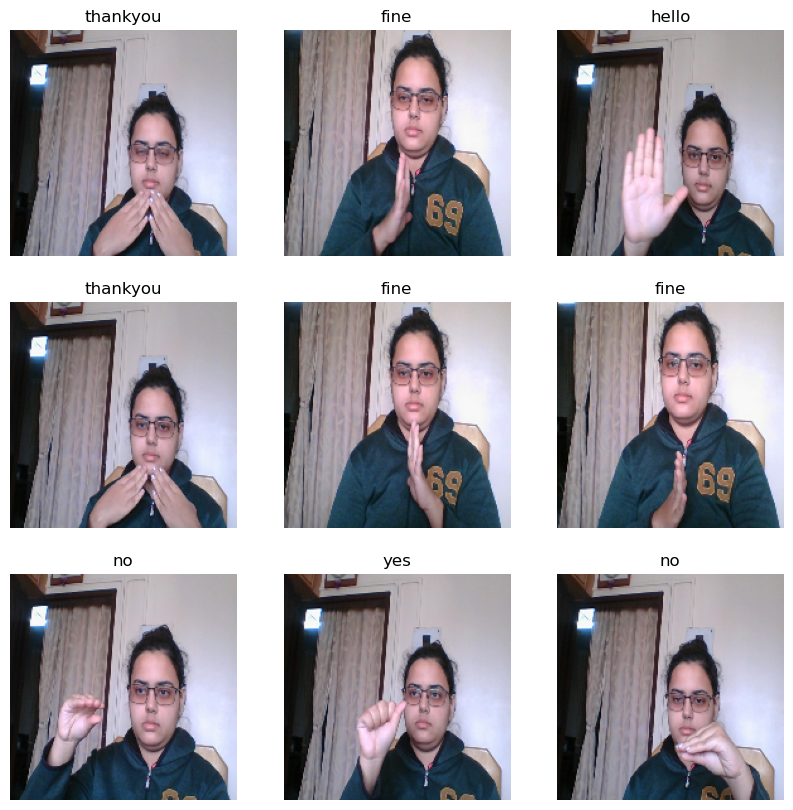

In [13]:
import matplotlib.pyplot as plt

class_names = ['hello', 'fine', 'no', 'thankyou', 'yes']
plt.figure(figsize=(10, 10))
for images, labels in dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
from tensorflow.keras import layers, models
model = models.Sequential([
    layers.Rescaling(1./255, input_shape=(180, 180, 3)),
    layers.Conv2D(16, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(32, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Conv2D(64, 3, padding='same', activation='relu'),
    layers.MaxPooling2D(),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dense(5)
])

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 45, 45, 64)        1

In [16]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


In [17]:
CHECKPOINT_FILEPATH = 'training_1/cp.ckpt'
CHECKPOINT_DIR = os.path.dirname(CHECKPOINT_FILEPATH)

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=CHECKPOINT_FILEPATH,
                                                 monitor='val_accuracy',
                                                 mode='max',
                                                 save_weights_only=True,
                                                 verbose=1)
callbacks_list = [cp_callback]

In [18]:
history = model.fit(
  dataset,
  batch_size=BATCH_SIZE,
  validation_data=validation_dataset,
  epochs=10,
  callbacks=[cp_callback]
)

Epoch 1/10


4/4 [==============================] - ETA: 0s - loss: 2.2147 - accuracy: 0.2083
Epoch 1: saving model to training_1/cp.ckpt
4/4 [==============================] - 1s 195ms/step - loss: 2.2147 - accuracy: 0.2083 - val_loss: 1.5467 - val_accuracy: 0.4000
Epoch 2/10
4/4 [==============================] - ETA: 0s - loss: 1.4727 - accuracy: 0.3750
Epoch 2: saving model to training_1/cp.ckpt
4/4 [==============================] - 1s 157ms/step - loss: 1.4727 - accuracy: 0.3750 - val_loss: 1.3424 - val_accuracy: 0.4000
Epoch 3/10
4/4 [==============================] - ETA: 0s - loss: 1.2661 - accuracy: 0.5250
Epoch 3: saving model to training_1/cp.ckpt
4/4 [==============================] - 1s 165ms/step - loss: 1.2661 - accuracy: 0.5250 - val_loss: 1.1238 - val_accuracy: 0.6667
Epoch 4/10
4/4 [==============================] - ETA: 0s - loss: 1.0488 - accuracy: 0.6583
Epoch 4: saving model to training_1/cp.ckpt
4/4 [==============================] - 1s 171ms/step - loss: 1.0488 - accuracy: 

In [19]:
os.listdir(CHECKPOINT_DIR)

['cp.ckpt.data-00000-of-00001', 'checkpoint', 'cp.ckpt.index']

In [20]:
model.load_weights(CHECKPOINT_FILEPATH)

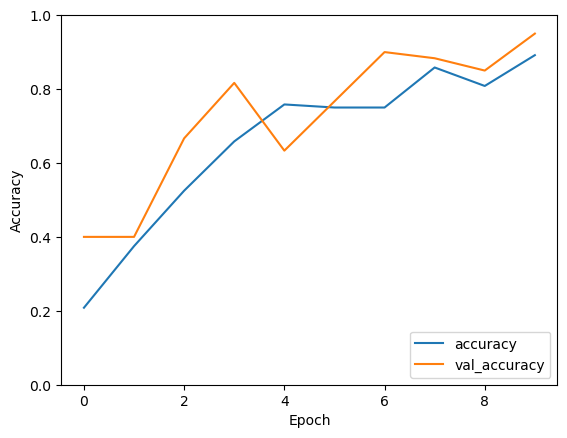

In [21]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0, 1])
plt.legend(loc='lower right')

Testing


In [22]:
test_accuracy = model.evaluate(test_dataset,steps=624)

624/624 [==============================] - 0s 18us/step - loss: 0.2578 - accuracy: 0.9333


In [23]:
!pip install opencv-python

In [24]:
import cv2

In [36]:
TEST_IMAGE_PATH = 'Split_Data/test/no/no.d9cb290a-bb53-11ee-b8ab-2cdb079ec43c.jpg'

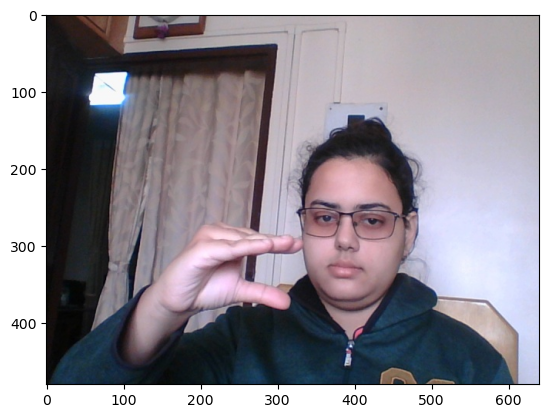

In [37]:
img = cv2.imread(TEST_IMAGE_PATH)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

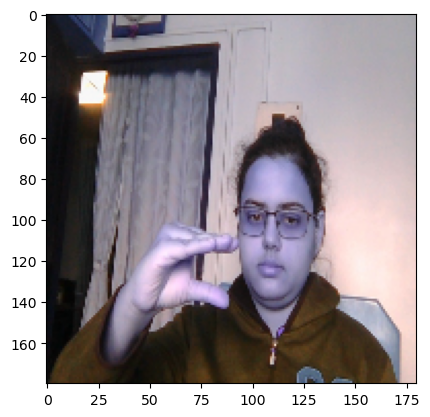

In [38]:
resize = tf.image.resize(img, (180,180))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
import numpy as np

In [40]:
prediction = model.predict(np.expand_dims(resize, 0))

1/1 [==============================] - 0s 22ms/step


In [41]:
np.expand_dims(resize, 0)

array([[[[ 21.796295 ,  19.962963 ,  24.240742 ],
         [ 23.333332 ,  23.       ,  29.       ],
         [ 15.37037  ,  22.212963 ,  34.194447 ],
         ...,
         [165.27771  , 165.27771  , 171.27771  ],
         [167.66667  , 165.66667  , 171.66667  ],
         [169.51851  , 165.27777  , 170.27777  ]],

        [[ 22.333334 ,  20.916668 ,  22.63889  ],
         [ 21.25     ,  20.083332 ,  23.916668 ],
         [ 16.833332 ,  20.916666 ,  31.       ],
         ...,
         [162.77771  , 165.77771  , 170.77771  ],
         [165.83331  , 167.33331  , 172.83331  ],
         [167.       , 166.86111  , 171.13889  ]],

        [[ 17.175924 ,  18.574074 ,  19.388887 ],
         [ 23.805555 ,  20.805555 ,  22.805555 ],
         [ 17.675926 ,  19.305555 ,  28.185186 ],
         ...,
         [165.12033  , 168.12033  , 173.12033  ],
         [163.99998  , 163.99998  , 169.99998  ],
         [165.72223  , 166.72223  , 170.72223  ]],

        ...,

        [[ 13.250063 ,  11.277828 ,  1

In [30]:
type(resize)

tensorflow.python.framework.ops.EagerTensor

In [42]:
prediction

array([[ 0.50298846, -5.6805954 ,  2.7811627 ,  2.0931845 ,  2.4184277 ]],
      dtype=float32)

In [43]:
predictions = np.array(prediction)

# Find the index of the maximum value in the array
predicted_class_index = np.argmax(predictions)

# Output the predicted class index
print("Predicted class index:", predicted_class_index)


if predicted_class_index==0: 
    print(f'Predicted class is Hello')
elif predicted_class_index==1:
    print(f'Predicted class is Fine')
elif predicted_class_index==2:
    print(f'Predicted class is No')
elif predicted_class_index==3:
    print(f'Predicted class is Thank You')
elif predicted_class_index==4:
    print(f'Predicted class is Yes')

Predicted class index: 2
Predicted class is No


In [33]:
model.save('cnn_10ep_ac1.h5')

/Users/shaimahaque/anaconda3/lib/python3.11/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [34]:
model.save('cnn_10ep_ac1.keras')